# Konvoluční sítě pro klasifikaci

Úkolem cvičení je upravit tento notebook a dosáhnout co nejlepšího možného validačního skóre na datasetu CIFAR-10. Viz nápovědu a možné směry úprav v komentářích u jednotlivých buněk. Klasifikaci obrázků pomocí konvolučních sítí v PyTorch popisuje notebook [pytorch-convnets](lectures/pytorch-convnets.ipynb). 

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import ans

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Načtení CIFAR10

In [38]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [39]:
# zlepsi predzpracovani a jine augmentace skore?
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [40]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [41]:
# augmentaci lze provadet i v testovacim rezimu
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [42]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [43]:
# pomuze jina batch_size?
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Kritérium

In [44]:
# muze zlepsit skore napr. SVM?
crit = nn.CrossEntropyLoss()
crit

CrossEntropyLoss()

## Definice konvoluční sítě

Síť definujte následující třídou `Convnet`. Architekturu síťě můžete navrhnout sami ručně, nebo lze použít jeden z existujících modelů, např. z katalogu `torchvision.models`. Není povoleno použít předtrénovaný model, tj. s vahami již natrénovanými na jiných datasetech, např. ImageNet.

In [55]:
class Convnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.fc.requires_grad = False
        self.model.avgpool.requires_grad = False
        self.model.avgpool = nn.Conv2d(512, 64, 3, padding=1, bias=False)
        self.model.fc = nn.Linear(64,10)
    
    def forward(self, x):
        x = self.model(x)
        return x

## Trénování a validace

In [56]:
# pokud vytvorime novou sit, vyresetujeme i statistiky
convnet = Convnet()
stats = ans.Stats()

In [32]:
# chceme-li vyuzit GPU, jinak nevolat
convnet.to('cuda')

AssertionError: Torch not compiled with CUDA enabled

In [57]:
for name, par in convnet.named_parameters():
    print(name, par.shape, par.numel())

model.conv1.weight torch.Size([64, 3, 7, 7]) 9408
model.bn1.weight torch.Size([64]) 64
model.bn1.bias torch.Size([64]) 64
model.layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) 36864
model.layer1.0.bn1.weight torch.Size([64]) 64
model.layer1.0.bn1.bias torch.Size([64]) 64
model.layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) 36864
model.layer1.0.bn2.weight torch.Size([64]) 64
model.layer1.0.bn2.bias torch.Size([64]) 64
model.layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) 36864
model.layer1.1.bn1.weight torch.Size([64]) 64
model.layer1.1.bn1.bias torch.Size([64]) 64
model.layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) 36864
model.layer1.1.bn2.weight torch.Size([64]) 64
model.layer1.1.bn2.bias torch.Size([64]) 64
model.layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) 73728
model.layer2.0.bn1.weight torch.Size([128]) 128
model.layer2.0.bn1.bias torch.Size([128]) 128
model.layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) 147456
model.layer2.0.bn2.weight torch.Size([128]) 128
model.

In [58]:
# s novou siti musime obnovit i seznam parametru pro optimizer
# lepsich vysledku obvykle dosahuje SGD s momentum nebo napr. metoda Adam
optimizer = torch.optim.SGD(convnet.parameters(), lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [59]:
# jaky vliv ma pocet epoch?
# zkuste postupne menit learning rate (optimizer.param_groups[0]['lr'] = ...)
# nebo pomoci scheduleru (https://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate)
for ep in range(1):
    stats.new_epoch()
    ans.train_pytorch(convnet, crit, train_loader, optimizer, stats)
    ans.validate_pytorch(convnet, crit, test_loader, stats)

KeyboardInterrupt: 

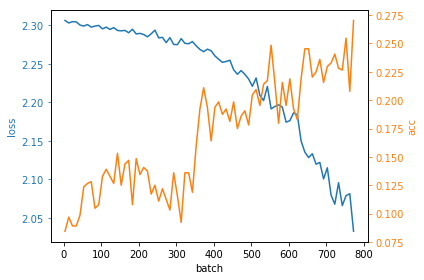

In [50]:
stats.plot_by_batch(block_len=10)

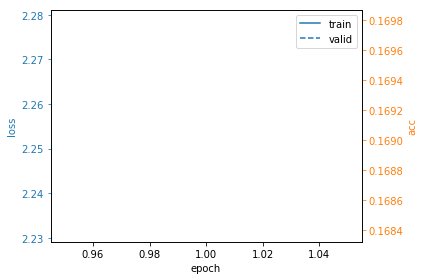

In [51]:
stats.plot_by_epoch()

In [52]:
stats.best_results()

Epoch 01,loss,acc
train,2.231456,0.169797
valid,2.278726,0.168392


## Predikce na testovacím obrázku

In [53]:
rgb_test = cv2.imread('./data/happy-green-frog.jpg')[..., ::-1]

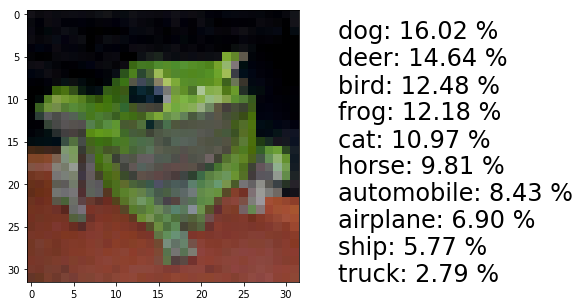

In [54]:
ans.predict_and_show(cv2.resize(rgb_test, (32, 32)), convnet, test_transform, classes=classes)